In [12]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\ank10ki\Dropbox\phd\Image analysis\ColonyImages`


In order to speed up computation, the creation and analysis of the colonies is multithreaded. To further enhance performance, execute this notebook with a Julia kernel that utilizes more threads, ideally matching the number of threads your CPU supports. Learn how to set up a Julia kernel with more threads [here](https://discourse.julialang.org/t/enable-multiple-cores-for-jupyter-lab/18658/5).

In [13]:
Threads.nthreads()

1

In [14]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization
import ColorSchemes as co 

In [15]:
df = DataFrame(data_set =String[], colony = String[], time = Int[], 
    metric_OG =Vector{Vector{Int64}}(undef,0), metric_cov = Vector{Vector{Int64}}(undef,0),
    pair_OG =Vector{Vector{Int64}}(undef,0),pair_cov =Vector{Vector{Int64}}(undef,0),
    OG_size = Int[], border_points =Vector{Vector{CartesianIndex{2}}}(undef,0), Parameters = Vector{parameters}(undef,0) )

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,border_points,Parameters
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,paramete…


In [16]:
para = parameters(
        im_size = [1600,1600],
        time_points = [0:2.0:52...],
        colony_nr = 8, 
        number_finger = 15,
        spawn_rate = 0.1,
        dir_match_rate_C = 0.9993,
        dir_match_rate_B = 0.9993,
        growth_rate = [0.02971700864000873,0.0,.0,.0],
        simulations = ["Random", "Finger_weak", "Finger_strong"])


#simulations = ["Random"]
Points= lattice_points(Int(maximum(para.im_size)÷2));

## Create empty datastructure for colony images

In [17]:
vec_of_sims = initialize_colonies(para)

3-element Vector{Vector{BitArray{3}}}:
 [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0

In [26]:
for (x,sim) in collect(enumerate(simulations))
    Threads.@threads for (i,colony) in collect(enumerate(vec_of_sims[x]))
        for (j,t) in enumerate(para.time_points)
            # use view to work on array directly 
            int_img  = @view colony[:,:,j]
            dir_vec = generate_dir_vec(para)
            if j == 1
                build_artifical_colony!(para.Center,int_img,para.radius_colony,Points)
                #pixel_to_add_vec = para.pixel_to_add(int_img)
            else
                # for unkown reason views require [:] to make assignments 
                int_img[:] = colony[:,:,j-1]
                if sim == "Random"
                    expand_colony_radom_cov!(int_img,pixel_to_add_vec[j-1])
                elseif sim == "Finger_weak"
                    expand_colony_finger_radom_cov!(int_img,pixel_to_add_vec[j-1],dir_vec,still_spawn_rate= para.spawn_rate, dir_match_rate = para.dir_match_rate_B)
                elseif sim == "Finger_strong"
                    expand_colony_finger_radom_cov!(int_img,pixel_to_add_vec[j-1],dir_vec, still_spawn_rate= 0.0,dir_match_rate = para.dir_match_rate_C)
                end
            end
        end
    end   
end

### Plot first colony test wise to see if everything worked as intended

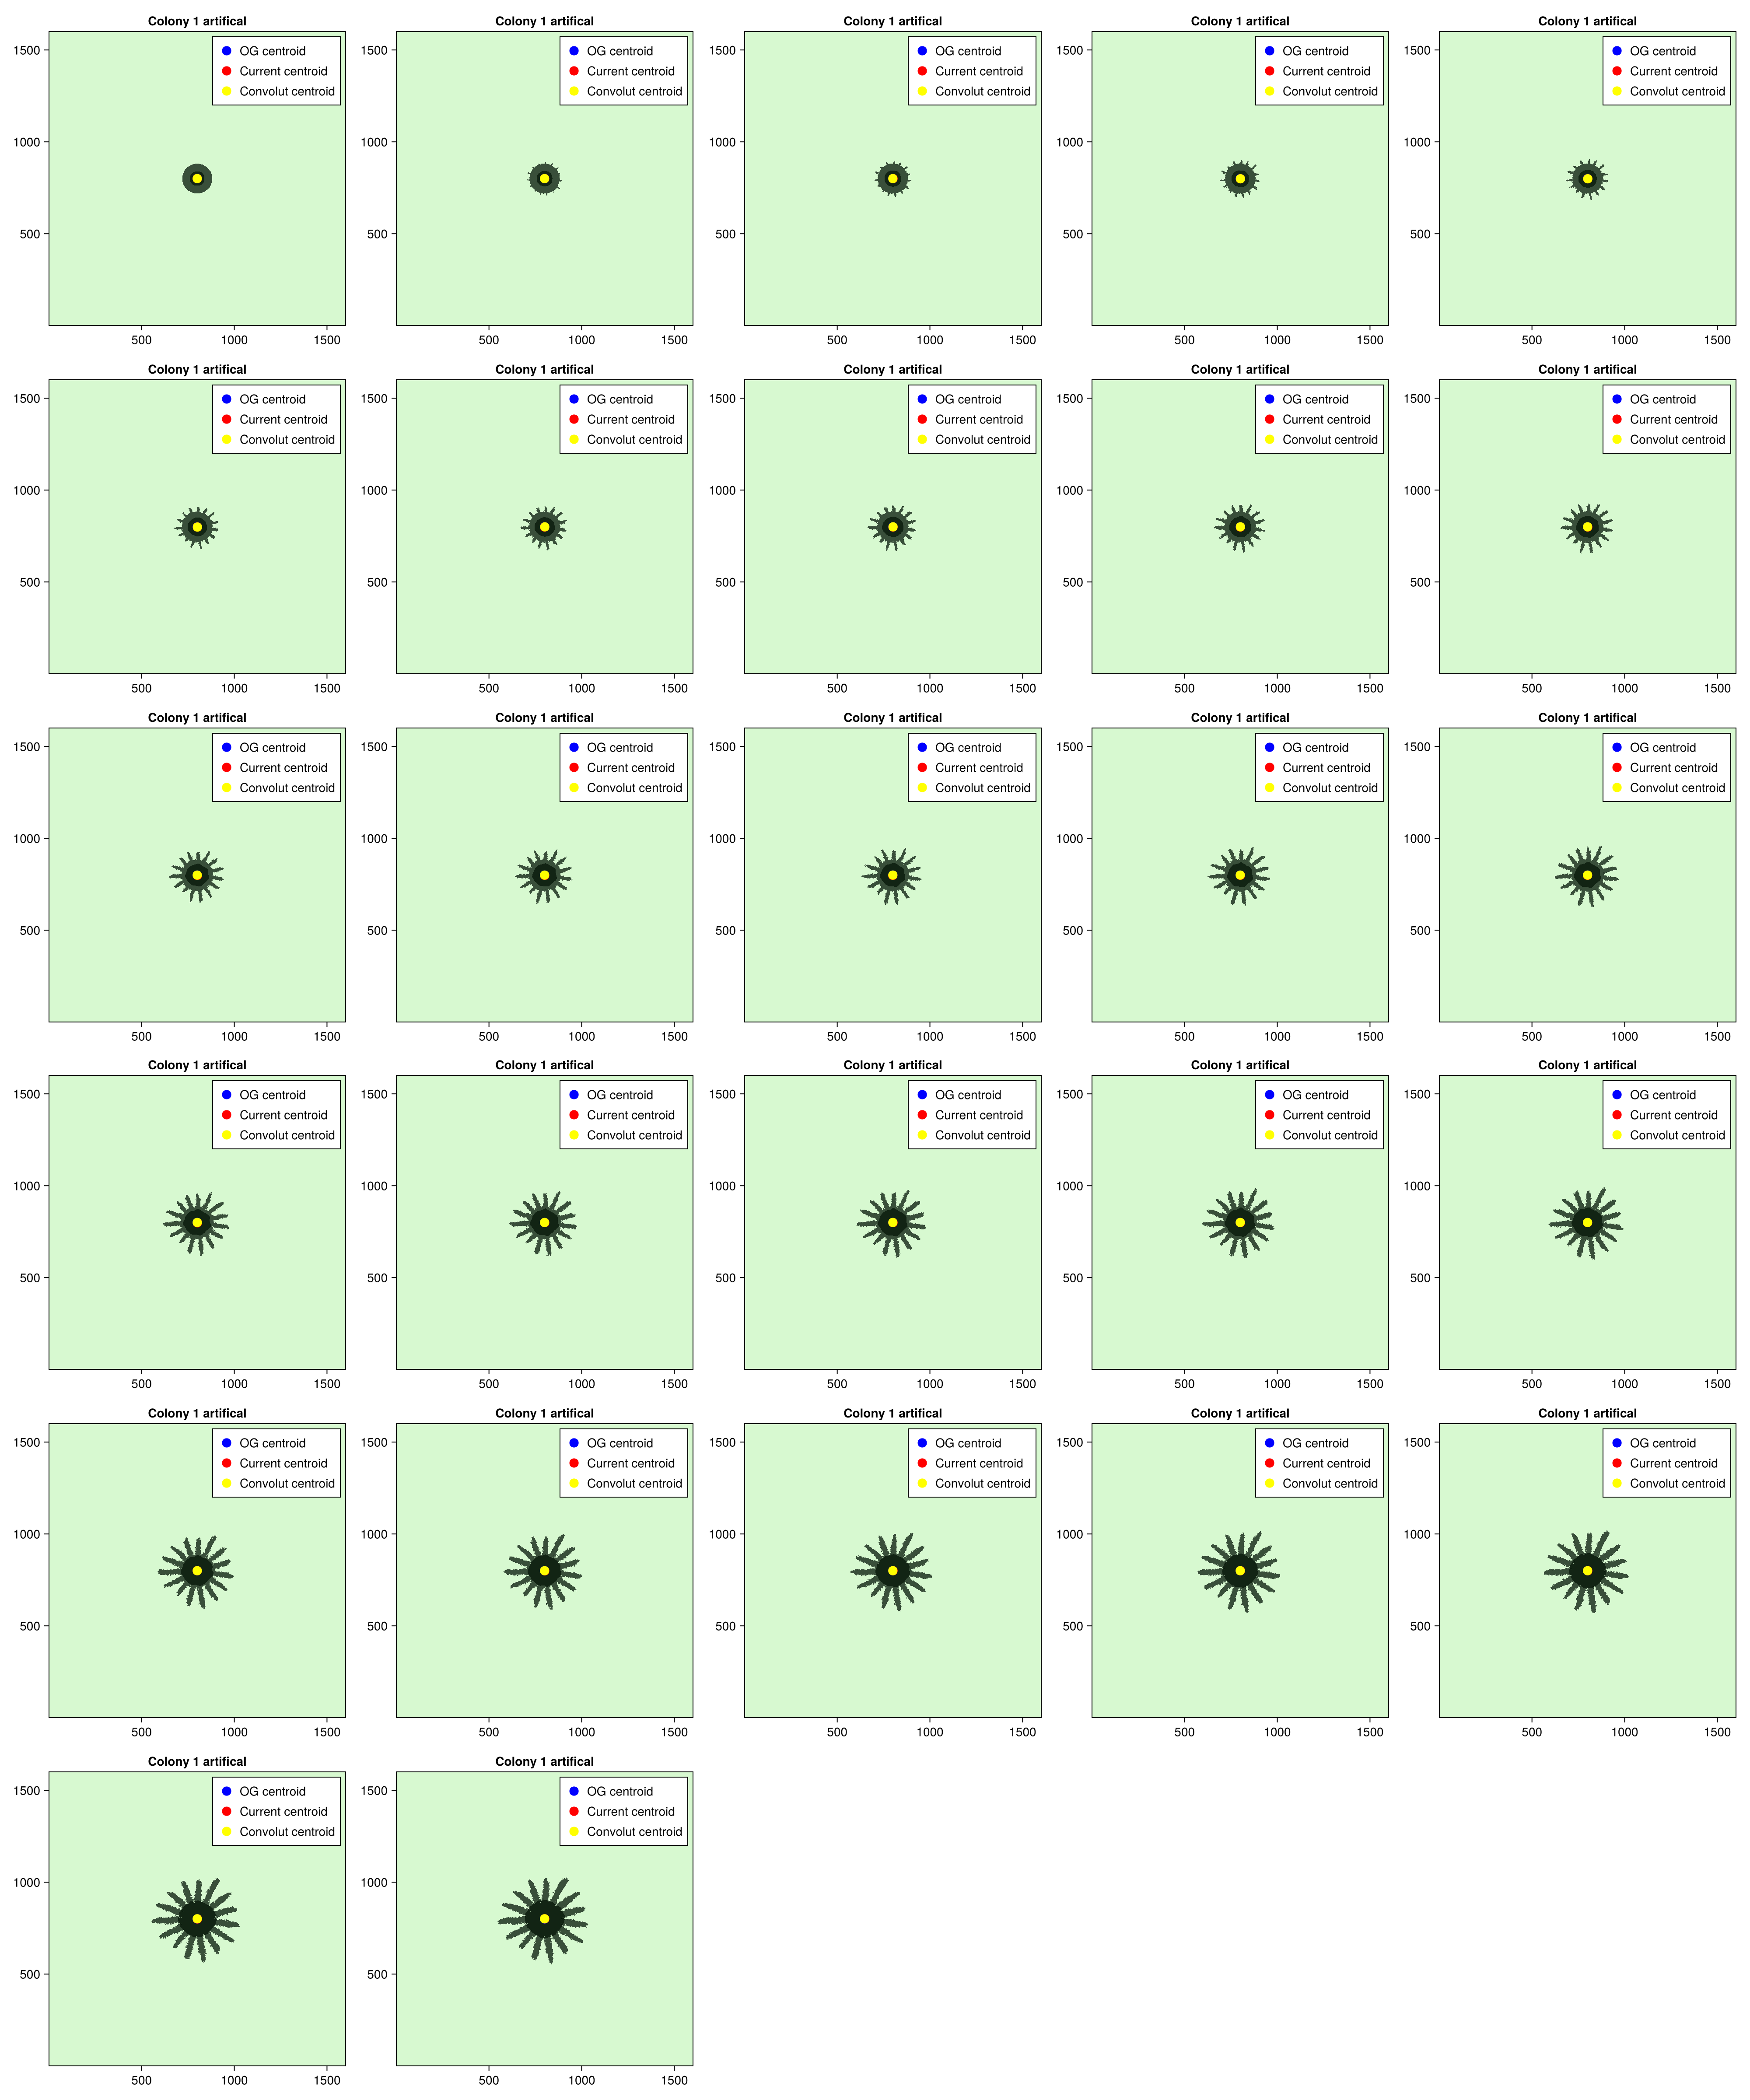

In [27]:
fig_test = plot_time_series_cov_centroid(vec_of_sims[2][1:1], para)

###  Calculate and append metrics to Dataframe

In [28]:
for (i,name) in collect(enumerate(simulations))
    save_time_series_metrics!(vec_of_sims[i], para,df,Points, name_data = name)
end

In [29]:
first(df,2)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,border_points,Parameters
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,paramete…
1,Random 2024_06_11,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 63]","[5396, 5495, 5577, 5537, 5752, 5442, 5568, 5586, 5584, 5547 … 5507, 5599, 5553, 5523, 5486, 5610, 5555, 5492, 5418, 5531]","[5532, 5495, 5511, 5619, 5597, 5482, 5490, 5497, 5569, 5558 … 5602, 5601, 5649, 5375, 5376, 5695, 5514, 5444, 5572, 5606]",20589,"CartesianIndex{2}[CartesianIndex(788, 720), CartesianIndex(789, 720), CartesianIndex(790, 720), CartesianIndex(791, 720), CartesianIndex(792, 720), CartesianIndex(793, 720), CartesianIndex(794, 720), CartesianIndex(795, 720), CartesianIndex(796, 720), CartesianIndex(797, 720) … CartesianIndex(803, 880), CartesianIndex(804, 880), CartesianIndex(805, 880), CartesianIndex(806, 880), CartesianIndex(807, 880), CartesianIndex(808, 880), CartesianIndex(809, 880), CartesianIndex(810, 880), CartesianIndex(811, 880), CartesianIndex(812, 880)]","parameters([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0 … 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0, 52.0], 0.8, 0.8, 0.4, 360, 2000000, 300, [1600, 1600], 27, 80, [800, 800], [0.029717, 0.0, 0.0, 0.0], #5, 0.01, [0 1 0; 1 -4 1; 0 1 0], 8, [""Colony 1 artifical"", ""Colony 2 artifical"", ""Colony 3 artifical"", ""Colony 4 artifical"", ""Colony 5 artifical"", ""Colony 6 artifical"", ""Colony 7 artifical"", ""Colony 8 artifical""], 2.0, [0.0, 0.0603171, 0.124272, 0.192085, 0.263988, 0.340229, 0.421067, 0.506782, 0.597667, 0.694033 … 1.7065, 1.86975, 2.04284, 2.22638, 2.42099, 2.62733, 2.84612, 3.07811, 3.32409, 3.5849], [0.0603171, 0.0639553, 0.0678129, 0.0719031, 0.0762401, 0.0808387, 0.0857147, 0.0908847, 0.0963667, 0.102179 … 0.153962, 0.163248, 0.173095, 0.183536, 0.194606, 0.206344, 0.21879, 0.231987, 0.24598, 0.260816], 15, 0.1, #7, 0.1, 0.9993, 0.9993)"
2,Random 2024_06_11,Colony 1 artifical,2,"[8, 6, 3, 3, 1, 0, 3, 4, 7, 4 … 6, 2, 3, 2, 4, 2, 1, 1, 1, 8]","[4, 2, 1, 2, 2, 2, 1, 2, 3, 2 … 5, 4, 1, 0, 0, 2, 2, 2, 3, 4]","[5264, 7407, 5776, 5670, 5827, 5634, 5379, 5320, 5711, 5447 … 5906, 5978, 5359, 5468, 5790, 5785, 5428, 5156, 6175, 5424]","[4757, 7974, 5560, 5346, 6232, 5575, 6005, 5138, 5601, 6365 … 6081, 5600, 5202, 6041, 5553, 5897, 4928, 5526, 6377, 5756]",20589,"CartesianIndex{2}[CartesianIndex(800, 714), CartesianIndex(787, 715), CartesianIndex(788, 715), CartesianIndex(789, 715), CartesianIndex(800, 715), CartesianIndex(801, 715), CartesianIndex(789, 716), CartesianIndex(800, 716), CartesianIndex(802, 716), CartesianIndex(813, 716) … CartesianIndex(801, 883), CartesianIndex(806, 883), CartesianIndex(808, 883), CartesianIndex(809, 883), CartesianIndex(784, 884), CartesianIndex(785, 884), CartesianIndex(787, 884), CartesianIndex(791, 884), CartesianIndex(786, 885), CartesianIndex(791, 885)]","parameters([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0 … 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0, 52.0], 0.8, 0.8, 0.4, 360, 2000000, 300, [1600, 1600], 27, 80, [800, 800], [0.029717, 0.0, 0.0, 0.0], #5, 0.01, [0 1 0; 1 -4 1; 0 1 0], 8, [""Colony 1 artifical"", ""Colony 2 artifical"", ""Colony 3 artifical"", ""Colony 4 artifical"", ""Colony 5 artifical"", ""Colony 6 artifical"", ""Colony 7 artifical"", ""Colony 8 artifical""], 2.0, [0.0, 0.0603171, 0.124272, 0.192085, 0.263988, 0.340229, 0.421067, 0.506782, 0.597667, 0.694033 … 1.7065, 1.86975, 2.04284, 2.22638, 2.42099, 2.62733, 2.84612, 3.07811, 3.32409, 3.5849], [0.0603171, 0.0639553, 0.0678129, 0.0719031, 0.0762401, 0.0808387, 0.0857147, 0.0908847, 0.0963667, 0.102179 … 0.153962, 0.163248, 0.173095, 0.183536, 0.194606, 0.206344, 0.21879, 0.231987, 0.24598, 0.260816], 15, 0.1, #7, 0.1, 0.9993, 0.9993)"


In [30]:
name_of_sim = "(para.colony_nr)_col_(length(simulations))_$(para.number_finger)_fingers"
path_metric = joinpath("data", "metrics")
mkpath(path_metric)

"data\\metrics"

In [31]:
serialize(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).jls"),df)
CSV.write(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).csv"),df)

"data\\metrics\\(para.colony_nr)_col_(length(simulations))_15_fingers2024_06_11.csv"